### installation for colab
To Run in Colab: uncomment and run the following

In [2]:
!git clone https://github.com/AssistiveRoboticsUNH/bc_tutorial.git
!pip install gym==0.26.2

Cloning into 'bc_tutorial'...
remote: Enumerating objects: 344, done.
remote: Total 344 (delta 0), reused 0 (delta 0), pack-reused 344 (from 1)
Receiving objects: 100% (344/344), 69.53 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (190/190), done.
Updating files: 100% (56/56), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827728 sha256=86f8dd9cd79703c79eb378e8ed028cfcb801536cfcae4c10e6d7ada37935470f
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pickle
import imageio

### Prepare data

In [8]:
# data_path = "expert_data/human_demos_4_-111.0.pkl"
data_path = "/content/bc_tutorial/mountain_car/expert_data/human_demos_4_-111.0.pkl"


with open(data_path, 'rb') as f:
    trajs = pickle.load(f)

print(f"Number of trajectories: {len(trajs)}")

Number of trajectories: 4


In [10]:
states=[]
actions=[]
for traj in trajs:
    for state,action in traj:

        states.append(state)
        actions.append(action)

states=np.array(states)
actions=np.array(actions)

states.shape,actions.shape

[-0.55180854  0.00122044] 2
[-0.5493767   0.00243176] 2
[-0.54575187  0.0036249 ] 2
[-0.5409609   0.00479093] 2
[-0.53503984  0.00592109] 2
[-0.52803296  0.00700688] 2
[-0.5199928   0.00804013] 2
[-0.5109797   0.00901309] 2
[-0.50106126  0.00991847] 2
[-0.4903117   0.01074956] 2
[-0.47881138  0.01150033] 2
[-0.46664596  0.01216543] 2
[-0.45390558  0.01274036] 2
[-0.44068414  0.01322146] 2
[-0.42707813  0.01360599] 2
[-0.41318598  0.01389216] 2
[-0.39910683  0.01407913] 2
[-0.38493985  0.01416699] 2
[-0.37078306  0.01415678] 2
[-0.35673267  0.01405039] 2
[-0.34288216  0.01385052] 2
[-0.3293216   0.01356057] 2
[-0.318137    0.01118459] 0
[-0.3093976   0.00873937] 0
[-0.30315647  0.00624117] 0
[-0.2994507   0.00370576] 0
[-0.2983022   0.00114851] 0
[-0.29971766 -0.00141547] 0
[-0.30368882 -0.00397116] 0
[-0.31019223 -0.00650342] 0
[-0.31918907 -0.00899684] 0
[-0.3306247  -0.01143562] 0
[-0.34442812 -0.01380343] 0
[-0.36051157 -0.01608343] 0
[-0.37876993 -0.01825836] 0
[-0.39908066 -0.0203

((438, 2), (438,))

In [ ]:
num_classes = np.max(actions)+1
num_classes

3

In [ ]:
data_loader = torch.utils.data.DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True)

batch=next(iter(data_loader))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 2]), torch.Size([64]))

### Training

In [ ]:
class BcNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(BcNet, self).__init__()
        self.layer1 = nn.Linear(state_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, action_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        # x = F.softmax(x, dim=1)
        return x

In [ ]:
bc= BcNet(2, 3)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(bc.parameters(), lr = learning_rate)

In [ ]:
loss_list = []
n_epoch = 250

for itr in range(0, n_epoch+1):
    for batch_states, batch_actions in data_loader:
        y_pred = bc(batch_states)
        loss = criterion(y_pred, batch_actions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if itr % 10 == 0:
        print(f'iteration: {itr}, loss: {loss.item()}')

iteration: 0, loss: 0.7623139023780823
iteration: 10, loss: 0.46693503856658936
iteration: 20, loss: 0.12156796455383301
iteration: 30, loss: 0.08797335624694824
iteration: 40, loss: 0.11853441596031189
iteration: 50, loss: 0.1830071061849594
iteration: 60, loss: 0.20077437162399292
iteration: 70, loss: 0.05155340954661369
iteration: 80, loss: 0.041541144251823425
iteration: 90, loss: 0.11805929243564606
iteration: 100, loss: 0.07951048016548157
iteration: 110, loss: 0.052611660212278366
iteration: 120, loss: 0.2533944249153137
iteration: 130, loss: 0.03072521649301052
iteration: 140, loss: 0.10042694211006165
iteration: 150, loss: 0.05507858097553253
iteration: 160, loss: 0.022443490102887154
iteration: 170, loss: 0.031161952763795853
iteration: 180, loss: 0.137659952044487
iteration: 190, loss: 0.07306943833827972
iteration: 200, loss: 0.1001579761505127
iteration: 210, loss: 0.1104620173573494
iteration: 220, loss: 0.032606445252895355
iteration: 230, loss: 0.06138146296143532
itera

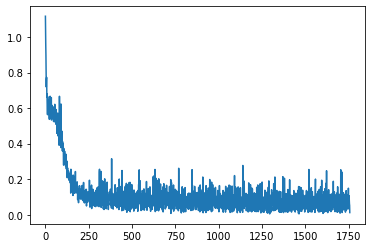

In [ ]:
plt.plot(loss_list)

In [ ]:
bc.eval()
train_x=torch.tensor(states).float()
train_y=torch.tensor(actions).long()
with torch.no_grad():
    y_pred = bc(train_x)
    correct = (torch.argmax(y_pred, dim=1) == train_y ).type(torch.FloatTensor)
    print('training accuracy: ', correct.mean())

training accuracy:  tensor(1.)


### Rollout

In [ ]:
env_name='MountainCar-v0'

In [ ]:
def play_an_episode(env_name, model, video_path=None, max_steps=1000):
    video_writer=None
    if video_path is not None:
        print(f'Saving video to {video_path}')
        video_writer = imageio.get_writer(video_path, fps=20)
        env=gym.make(env_name, render_mode='rgb_array')
    else:
        env=gym.make(env_name)

    obs,_=env.reset()
    rewards=0
    step=0
    for _ in range(max_steps):
        step+=1
        obs=torch.tensor(obs).float()
        predict=model(obs)
        action=torch.argmax(predict).item()
        obs, reward, done, trunc,_ = env.step(action)

        if video_path is not None:
            image=env.render()
            video_writer.append_data(image)

        rewards+=reward
        if done or trunc:
            break

    if video_path is not None:
        video_writer.close()
    return {'reward':rewards, 'step':step-1}

In [ ]:
scores=[]
n_trajectory=20
for i in range(n_trajectory):
    stats=play_an_episode(env_name, bc)
    rewards=stats['reward']
    print(f'episode #{i} reward: {rewards:0.2f}')
    scores.append(rewards)

print(f'\n score: {np.mean(scores):0.2f} +- {np.std(scores):0.2f}')

episode #0 reward: -200.00
episode #1 reward: -200.00
episode #2 reward: -121.00
episode #3 reward: -113.00
episode #4 reward: -200.00
episode #5 reward: -112.00
episode #6 reward: -114.00
episode #7 reward: -116.00
episode #8 reward: -117.00
episode #9 reward: -112.00
episode #10 reward: -114.00
episode #11 reward: -122.00
episode #12 reward: -115.00
episode #13 reward: -200.00
episode #14 reward: -113.00
episode #15 reward: -117.00
episode #16 reward: -113.00
episode #17 reward: -120.00
episode #18 reward: -112.00
episode #19 reward: -200.00

 score: -136.55 +- 36.74


### Let's render and save a video using the learned policy.

In [ ]:
stats=play_an_episode(env_name, bc, video_path='bc_mc.mp4')
stats

Saving video to bc_mc.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f60480] Warning: data is not aligned! This can lead to a speed loss


{'reward': -112.0, 'step': 111}

In [ ]:
# from IPython.display import Video
# Video('bc_mc.mp4' )

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = 'bc_mc.mp4'

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")